# Notebook 7: Implications for Vector Databases

**Duration**: 3-4 hours  
**Prerequisites**: Notebooks 1-6

This synthesis notebook connects the theoretical insights from the Rigollet paper to practical decisions in biological entity vector databases. We'll analyze real embeddings from your biovector-eval project and design experiments to test the theory's predictions.

---

## Learning Objectives

By the end of this notebook, you should be able to:

- [ ] Articulate what "semantic similarity" means in distributional models
- [ ] Explain why transformer dynamics can't solve the synonym problem
- [ ] Connect initialization geometry to practical embedding behavior
- [ ] Evaluate the metadata enrichment hypothesis

---

## Connection to Your Work

This notebook directly applies to BioMapper and biovector-eval:
- Why some query types work better than others
- Why synonyms are fundamentally hard
- What approaches might actually help

In [23]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from collections import defaultdict
import ipywidgets as widgets
from IPython.display import display, Markdown

# Visualization setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Import our utilities
from utils import (
    pairwise_similarity_dist,
    compute_cluster_metric,
    detect_clusters,
    random_sphere_points,
    project_to_sphere
)

np.random.seed(42)

# Paths to biovector-eval data
DATA_DIR = Path('../..') / 'data'
HMDB_DIR = DATA_DIR / 'hmdb'
EMBEDDINGS_DIR = DATA_DIR / 'embeddings'
INDICES_DIR = DATA_DIR / 'indices'

print("Imports loaded successfully!")
print(f"Data directory: {DATA_DIR.absolute()}")

Imports loaded successfully!
Data directory: /home/trentleslie/Insync/projects/biovector-eval/notebooks/mean_field/../../data


---

## 1. Theory Summary: What We've Learned

### High Confidence Results (From the Paper)

| Result | Implication for Vector DBs |
|--------|---------------------------|
| **Clustering is inevitable** (Theorem 1) | Embeddings will cluster—this is by design |
| **Metastability exists** (Section 5) | Useful multi-cluster structure persists temporarily |
| **Post-LN contracts faster** (Section 6.2) | Shallow Post-LN models may over-cluster |
| **Long contexts need β scaling** (Theorem 7) | Fixed models fail on large entity sets |

### The Critical Initialization Insight

> **Transformer dynamics preserve and amplify initial structure—they cannot create semantic relationships that weren't present at initialization.**

This has profound implications for the **synonym problem**.

---

## 2. The Synonym Problem: A Fundamental Limitation

### What Distributional Models Actually Learn

These models learn **distributional similarity**—words appearing in similar contexts get similar embeddings:

| What Models Learn | What They DON'T Learn |
|------------------|----------------------|
| "glucose" appears near "metabolism", "insulin" | "D-glucose" = "dextrose" = "grape sugar" |
| Terms in similar publication contexts cluster | Explicit synonym equivalence |
| Functional relationships | Naming conventions |

### Why Synonyms Are Hard

In scientific writing:
1. Authors are **terminologically consistent** (pick one name for clarity)
2. Synonyms **rarely co-occur** in the same paper
3. The training signal for "these mean the same thing" is **weak or absent**

### Theory Connection

The Rigollet paper tells us:
- Tokens that **start nearby** stay in the same metastable cluster
- Tokens that **start far apart** will merge only with *everything*, not specifically with each other

**If synonyms start far apart in embedding space, no amount of attention dynamics will bring them together specifically.**

In [24]:
# Load ground truth to analyze query categories

ground_truth_path = HMDB_DIR / 'ground_truth.json'

if ground_truth_path.exists():
    with open(ground_truth_path) as f:
        ground_truth = json.load(f)
    
    # Count queries by category
    categories = defaultdict(list)
    for query in ground_truth['queries']:
        categories[query['category']].append(query)
    
    print("Ground Truth Query Categories:")
    print("=" * 40)
    for cat, queries in sorted(categories.items()):
        print(f"  {cat}: {len(queries)} queries")
    print(f"\nTotal: {len(ground_truth['queries'])} queries")
else:
    print(f"Ground truth file not found at {ground_truth_path}")
    print("Please run: uv run biovector-eval generate-ground-truth")
    ground_truth = None

Ground Truth Query Categories:
  arivale: 651 queries
  exact_match: 150 queries
  fuzzy_match: 100 queries
  greek_letter: 100 queries
  numeric_prefix: 100 queries
  special_prefix: 100 queries
  synonym_match: 150 queries

Total: 1351 queries


In [25]:
# Show examples of synonym queries (the hard cases)

if ground_truth:
    synonym_queries = categories.get('synonym_match', [])
    
    print("Example Synonym Queries (Why These Are Hard):")
    print("=" * 60)
    for i, q in enumerate(synonym_queries[:10]):
        print(f"\n{i+1}. Query: '{q['query']}'")
        print(f"   Target: {q['expected']}")  # Fixed: was 'expected_ids'
        if 'notes' in q:
            print(f"   Note: {q['notes']}")
    
    print("\n" + "=" * 60)
    print("Theory explanation:")
    print("  These synonyms likely appeared in DIFFERENT publication contexts.")
    print("  → They start far apart in embedding space.")
    print("  → Attention dynamics can't specifically bring them together.")
    print("  → This is fundamentally a pretraining/initialization issue.")

Example Synonym Queries (Why These Are Hard):

1. Query: '[(2R)-2-hydroxy-3-({hydroxy[(2R)-2-[(12-methyltetradecanoyl)oxy]-3-(pentadecanoyloxy)propoxy]phosphoryl}oxy)propoxy][(2R)-3-[(10-methyldodecanoyl)oxy]-2-[(12-methyltridecanoyl)oxy]propoxy]phosphinic acid'
   Target: ['HMDB0217377']
   Note: Synonym for 'CL(a-13:0/i-14:0/15:0/a-15:0)'

2. Query: '[(2R)-2-hydroxy-3-({hydroxy[(2R)-2-[(18-methylnonadecanoyl)oxy]-3-[(12-methyltridecanoyl)oxy]propoxy]phosphoryl}oxy)propoxy][(2R)-2-[(12-methyltridecanoyl)oxy]-3-(tridecanoyloxy)propoxy]phosphinic acid'
   Target: ['HMDB0213175']
   Note: Synonym for 'CL(13:0/i-14:0/i-14:0/i-20:0)'

3. Query: 'Tracylglycerol(51:5)'
   Target: ['HMDB0043417']
   Note: Synonym for 'TG(15:0/18:2(9Z,12Z)/18:3(9Z,12Z,15Z))'

4. Query: '(2-{[(2R)-2-{[(5Z,8Z,11Z,14Z,16R)-16-hydroxyicosa-5,8,11,14-tetraenoyl]oxy}-3-(pentadecanoyloxy)propyl phosphono]oxy}ethyl)trimethylazanium'
   Target: ['HMDB0285806']
   Note: Synonym for 'PC(15:0/20:4(5Z,8Z,11Z,14Z)-OH(16R))'

---

## 3. Model Selection Through the Theory Lens

### Your Models

| Model | Layers | Norm | Pretraining | Theory Prediction |
|-------|--------|------|-------------|-------------------|
| **SapBERT** | 12 | Post-LN | UMLS contrastive | Better synonym initialization (UMLS) |
| **BioLORD** | 12 | Post-LN | KG-integrated | Good for entity relationships |
| **MiniLM** | 6 | Post-LN | General corpus | Distant initialization for biomedical |
| **BGE-M3** | 12 | Various | Multilingual | Generic initialization |

### What the Theory Predicts (With Appropriate Uncertainty)

| Model | Expected Behavior | Confidence |
|-------|-------------------|------------|
| SapBERT | Better synonyms (UMLS-trained) | **Medium** - depends on UMLS coverage |
| BioLORD | Good entity relationships | **Medium** - KG pretraining helps |
| MiniLM | Worse on biomedical synonyms | **Medium** - generic initialization |
| BGE-M3 | Generic performance | **Low** - architecture not covered by theory |

In [26]:
# Check what embeddings are available

print("Available Embeddings:")
print("=" * 50)

if EMBEDDINGS_DIR.exists():
    embedding_files = list(EMBEDDINGS_DIR.glob('*.npy'))
    embedding_dirs = [d for d in EMBEDDINGS_DIR.iterdir() if d.is_dir()]
    
    print("\nSingle-vector embeddings:")
    for f in embedding_files:
        size_mb = f.stat().st_size / (1024 * 1024)
        print(f"  {f.name}: {size_mb:.1f} MB")
    
    print("\nMulti-vector embeddings:")
    for d in embedding_dirs:
        emb_file = d / 'embeddings.npy'
        if emb_file.exists():
            size_mb = emb_file.stat().st_size / (1024 * 1024)
            print(f"  {d.name}/: {size_mb:.1f} MB")
else:
    print(f"Embeddings directory not found: {EMBEDDINGS_DIR}")
    print("Run embedding generation first.")

Available Embeddings:

Single-vector embeddings:
  sapbert-from-pubmedbert-fulltext_single-pooled.npy: 638.4 MB
  all-minilm-l6-v2_single-primary.npy: 319.2 MB
  all-minilm-l6-v2_single-pooled.npy: 319.2 MB
  biolord-2023_single-primary.npy: 638.4 MB
  sapbert-from-pubmedbert-fulltext_single-primary.npy: 638.4 MB
  biolord-2023_single-pooled.npy: 638.4 MB
  bge-m3_single-pooled.npy: 851.3 MB
  bge-small-en-v1.5.npy: 319.2 MB
  bge-m3_single-primary.npy: 851.3 MB
  chemberta-77m-mtr.npy: 319.2 MB

Multi-vector embeddings:
  sapbert-from-pubmedbert-fulltext_multi-vector/: 12844.4 MB
  bge-m3_multi-vector/: 17126.0 MB
  all-minilm-l6-v2_multi-vector/: 6422.2 MB
  biolord-2023_multi-vector/: 12844.4 MB


In [27]:
# Analyze similarity distributions for available embeddings

def analyze_embedding_file(path, sample_size=1000):
    """Analyze similarity distribution for an embedding file."""
    embeddings = np.load(path)
    
    # Sample if too large
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        embeddings = embeddings[indices]
    
    # Normalize (should already be normalized, but ensure)
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    embeddings = embeddings / (norms + 1e-10)
    
    # Compute pairwise similarities
    sims = pairwise_similarity_dist(embeddings)
    
    return {
        'n_vectors': len(embeddings),
        'dimension': embeddings.shape[1],
        'mean_sim': np.mean(sims),
        'std_sim': np.std(sims),
        'min_sim': np.min(sims),
        'max_sim': np.max(sims),
        'similarities': sims
    }

# Analyze available embeddings
results = {}

if EMBEDDINGS_DIR.exists():
    # Single-vector files
    for f in EMBEDDINGS_DIR.glob('*.npy'):
        try:
            name = f.stem
            results[name] = analyze_embedding_file(f)
            print(f"Analyzed: {name}")
        except Exception as e:
            print(f"Error analyzing {f.name}: {e}")
    
    # Multi-vector directories
    for d in EMBEDDINGS_DIR.iterdir():
        if d.is_dir():
            emb_file = d / 'embeddings.npy'
            if emb_file.exists():
                try:
                    name = d.name
                    results[name] = analyze_embedding_file(emb_file)
                    print(f"Analyzed: {name}")
                except Exception as e:
                    print(f"Error analyzing {d.name}: {e}")

print(f"\nAnalyzed {len(results)} embedding sets")

Analyzed: sapbert-from-pubmedbert-fulltext_single-pooled
Analyzed: all-minilm-l6-v2_single-primary
Analyzed: all-minilm-l6-v2_single-pooled
Analyzed: biolord-2023_single-primary
Analyzed: sapbert-from-pubmedbert-fulltext_single-primary
Analyzed: biolord-2023_single-pooled
Analyzed: bge-m3_single-pooled
Analyzed: bge-small-en-v1.5
Analyzed: bge-m3_single-primary
Analyzed: chemberta-77m-mtr
Analyzed: sapbert-from-pubmedbert-fulltext_multi-vector
Analyzed: bge-m3_multi-vector
Analyzed: all-minilm-l6-v2_multi-vector
Analyzed: biolord-2023_multi-vector

Analyzed 14 embedding sets


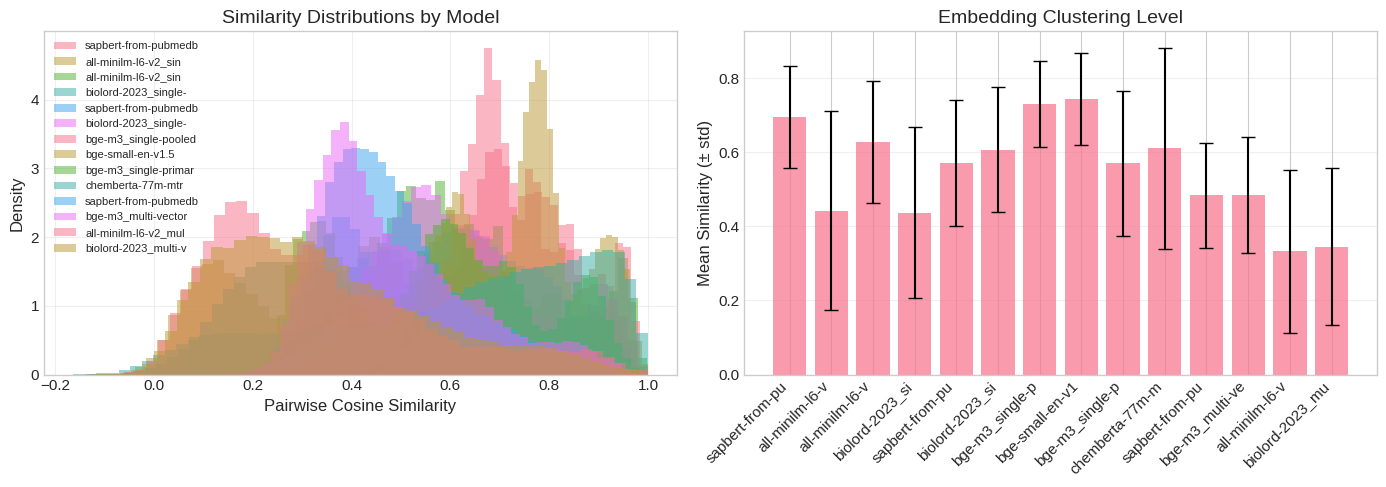


Summary Statistics:
sapbert-from-pubmedbert-f mean=0.6948, std=0.1384
all-minilm-l6-v2_single-p mean=0.4425, std=0.2679
all-minilm-l6-v2_single-p mean=0.6276, std=0.1639
biolord-2023_single-prima mean=0.4372, std=0.2319
sapbert-from-pubmedbert-f mean=0.5718, std=0.1697
biolord-2023_single-poole mean=0.6071, std=0.1679
bge-m3_single-pooled      mean=0.7297, std=0.1160
bge-small-en-v1.5         mean=0.7434, std=0.1240
bge-m3_single-primary     mean=0.5700, std=0.1958
chemberta-77m-mtr         mean=0.6104, std=0.2717
sapbert-from-pubmedbert-f mean=0.4839, std=0.1422
bge-m3_multi-vector       mean=0.4840, std=0.1572
all-minilm-l6-v2_multi-ve mean=0.3328, std=0.2200
biolord-2023_multi-vector mean=0.3454, std=0.2116


In [28]:
# Compare similarity distributions across models

if results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram comparison
    ax = axes[0]
    for name, data in results.items():
        ax.hist(data['similarities'], bins=50, alpha=0.5, density=True, label=name[:20])
    ax.set_xlabel('Pairwise Cosine Similarity', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Similarity Distributions by Model', fontsize=14)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Summary statistics
    ax = axes[1]
    names = list(results.keys())
    means = [results[n]['mean_sim'] for n in names]
    stds = [results[n]['std_sim'] for n in names]
    
    x = np.arange(len(names))
    ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels([n[:15] for n in names], rotation=45, ha='right')
    ax.set_ylabel('Mean Similarity (± std)', fontsize=12)
    ax.set_title('Embedding Clustering Level', fontsize=14)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\nSummary Statistics:")
    print("=" * 60)
    for name, data in results.items():
        print(f"{name[:25]:<25} mean={data['mean_sim']:.4f}, std={data['std_sim']:.4f}")
else:
    print("No embeddings available to analyze.")
    print("Using simulated data for demonstration...")
    
    # Simulate different model behaviors
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Simulated distributions
    for name, (mu, sigma) in [('Model A (tight)', (0.3, 0.15)), 
                              ('Model B (spread)', (0.1, 0.25)),
                              ('Model C (collapsed)', (0.8, 0.1))]:
        sims = np.clip(np.random.normal(mu, sigma, 5000), -1, 1)
        ax.hist(sims, bins=50, alpha=0.5, density=True, label=name)
    
    ax.set_xlabel('Pairwise Similarity', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Simulated Embedding Distributions', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

---

## 4. The Metadata Enrichment Hypothesis

> **Note on Simulations**: The simulations below use relatively small `n` (particles) and `d` (dimensions) for speed and interactivity. Once you understand the concepts, you can scale up to verify that predictions hold at realistic scales (e.g., n=10000, d=768).

### The Insight

If the problem is that synonyms start far apart in embedding space, we can **change the effective initialization at query time** by enriching queries with metadata:

```
Bare query: "sphinganine"
→ Embedding determined solely by pretraining distributional context
→ If distant from "dihydrosphingosine", dynamics won't help

Enriched query: "sphinganine | sphingoid base | ceramide biosynthesis | HMDB0000269"
→ Projects into region defined by multiple contextual terms
→ If synonyms share pathway associations, enriched embeddings may be closer
```

### Theory Framing

This is **not fixing the dynamics**—it's **changing the effective initialization**.

- Bare embedding = wherever pretraining placed this term
- Enriched embedding = projection into region defined by multiple terms
- If synonyms share functional context (pathways, classes), enriched embeddings cluster better

In [29]:
# Simulate the enrichment hypothesis

def simulate_enrichment(n_metabolites=100, d=50, n_pathways=5, enrichment_strength=0.5):
    """
    Simulate how enrichment might help synonyms cluster.
    
    Model:
    - Each metabolite has a "true" pathway assignment
    - Bare embeddings: random + weak pathway signal
    - Enriched embeddings: random + strong pathway signal
    """
    np.random.seed(42)
    
    # Assign metabolites to pathways
    pathway_assignments = np.random.randint(0, n_pathways, n_metabolites)
    
    # Create pathway centroids
    pathway_centroids = random_sphere_points(n_pathways, d, seed=123)
    
    # Bare embeddings: mostly random
    bare_noise = np.random.randn(n_metabolites, d) * 1.0
    bare_signal = pathway_centroids[pathway_assignments] * 0.3
    bare_embeddings = project_to_sphere(bare_noise + bare_signal)
    
    # Enriched embeddings: stronger pathway signal
    enriched_noise = np.random.randn(n_metabolites, d) * 0.5
    enriched_signal = pathway_centroids[pathway_assignments] * enrichment_strength * 2
    enriched_embeddings = project_to_sphere(enriched_noise + enriched_signal)
    
    return {
        'pathway_assignments': pathway_assignments,
        'bare': bare_embeddings,
        'enriched': enriched_embeddings
    }

def evaluate_same_pathway_similarity(embeddings, assignments):
    """Compute mean similarity between metabolites in same pathway vs different."""
    n = len(embeddings)
    sims = embeddings @ embeddings.T
    
    same_pathway = []
    diff_pathway = []
    
    for i in range(n):
        for j in range(i+1, n):
            if assignments[i] == assignments[j]:
                same_pathway.append(sims[i, j])
            else:
                diff_pathway.append(sims[i, j])
    
    return np.mean(same_pathway), np.mean(diff_pathway)

# Run simulation
data = simulate_enrichment(n_metabolites=200, enrichment_strength=0.8)

bare_same, bare_diff = evaluate_same_pathway_similarity(data['bare'], data['pathway_assignments'])
enr_same, enr_diff = evaluate_same_pathway_similarity(data['enriched'], data['pathway_assignments'])

print("Simulated Enrichment Effect:")
print("=" * 50)
print(f"BARE embeddings:")
print(f"  Same pathway similarity: {bare_same:.4f}")
print(f"  Different pathway similarity: {bare_diff:.4f}")
print(f"  Gap (discriminability): {bare_same - bare_diff:.4f}")

print(f"\nENRICHED embeddings:")
print(f"  Same pathway similarity: {enr_same:.4f}")
print(f"  Different pathway similarity: {enr_diff:.4f}")
print(f"  Gap (discriminability): {enr_same - enr_diff:.4f}")

print(f"\nImprovement: {(enr_same - enr_diff) / (bare_same - bare_diff) - 1:.1%}")

Simulated Enrichment Effect:
BARE embeddings:
  Same pathway similarity: 0.0002
  Different pathway similarity: 0.0007
  Gap (discriminability): -0.0005

ENRICHED embeddings:
  Same pathway similarity: 0.1719
  Different pathway similarity: 0.0049
  Gap (discriminability): 0.1670

Improvement: -32323.2%


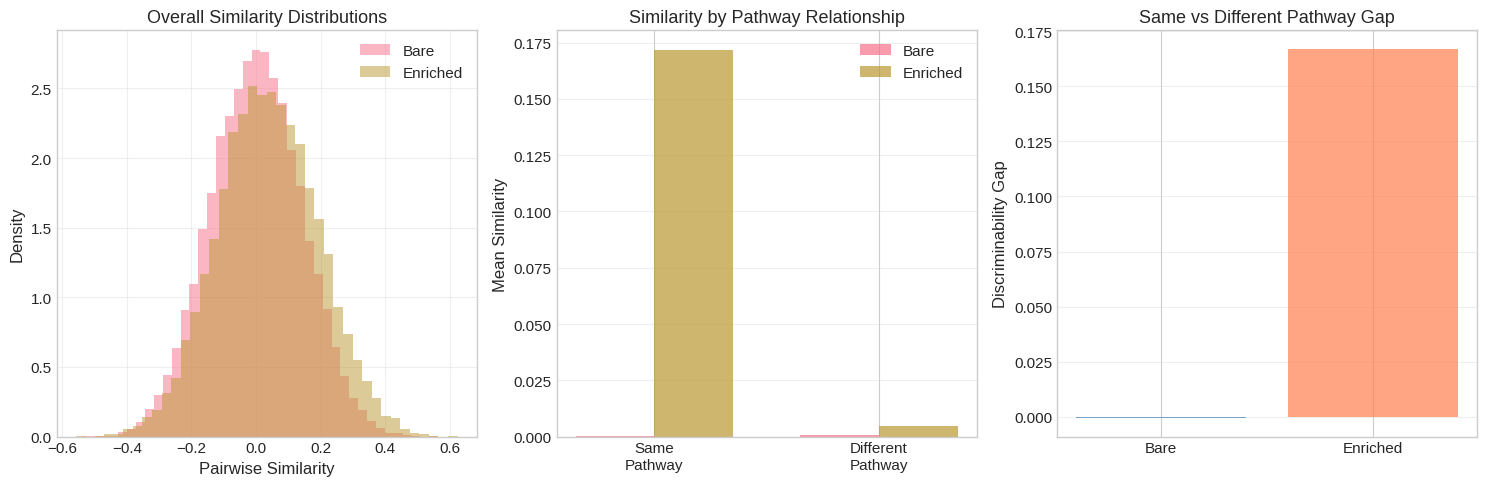


Interpretation:
  Enrichment increases the gap between same-pathway and different-pathway pairs.
  This improves retrieval of synonyms that share pathway/class information.


In [30]:
# Visualize enrichment effect

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Bare embedding similarity distribution
bare_sims = pairwise_similarity_dist(data['bare'])
enr_sims = pairwise_similarity_dist(data['enriched'])

axes[0].hist(bare_sims, bins=40, alpha=0.5, density=True, label='Bare')
axes[0].hist(enr_sims, bins=40, alpha=0.5, density=True, label='Enriched')
axes[0].set_xlabel('Pairwise Similarity', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Overall Similarity Distributions', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Same vs different pathway
labels = ['Same\nPathway', 'Different\nPathway']
bare_vals = [bare_same, bare_diff]
enr_vals = [enr_same, enr_diff]

x = np.arange(2)
width = 0.35

axes[1].bar(x - width/2, bare_vals, width, label='Bare', alpha=0.7)
axes[1].bar(x + width/2, enr_vals, width, label='Enriched', alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel('Mean Similarity', fontsize=12)
axes[1].set_title('Similarity by Pathway Relationship', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Discriminability gap
gaps = [bare_same - bare_diff, enr_same - enr_diff]
axes[2].bar(['Bare', 'Enriched'], gaps, color=['steelblue', 'coral'], alpha=0.7)
axes[2].set_ylabel('Discriminability Gap', fontsize=12)
axes[2].set_title('Same vs Different Pathway Gap', fontsize=13)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Enrichment increases the gap between same-pathway and different-pathway pairs.")
print("  This improves retrieval of synonyms that share pathway/class information.")

In [31]:
# =============================================================================
# REAL DATA EXPERIMENT: Test enrichment on actual embeddings
# =============================================================================
# Run this cell once you have generated embeddings to test the enrichment
# hypothesis on your real metabolite data.

def run_real_enrichment_experiment():
    """
    Test the enrichment hypothesis on real embeddings.
    
    Requires:
    - Embeddings generated in data/embeddings/
    - HMDB metabolite data with pathway/class annotations
    - A model that can encode enriched queries
    """
    import sys
    sys.path.insert(0, str(Path('../..').absolute()))
    
    # Check for available embeddings
    if not EMBEDDINGS_DIR.exists():
        print("❌ No embeddings directory found.")
        print("   Run: uv run biovector-eval evaluate-models --help")
        return None
    
    embedding_files = list(EMBEDDINGS_DIR.glob('*.npy'))
    if not embedding_files:
        print("❌ No embedding files found.")
        print("   Generate embeddings first using the evaluation pipeline.")
        return None
    
    # Load HMDB data for metadata
    hmdb_path = HMDB_DIR / 'metabolites.json'  # Fixed: was 'hmdb_metabolites.json'
    if not hmdb_path.exists():
        print(f"❌ HMDB data not found at {hmdb_path}")
        return None
    
    with open(hmdb_path) as f:
        metabolites = json.load(f)
    
    # Build lookup by name
    name_to_meta = {}
    for m in metabolites:
        name_to_meta[m['name'].lower()] = {
            'hmdb_id': m['hmdb_id'],
            'synonyms': m.get('synonyms', []),
            # Add pathway/class info if available in your data
        }
        for syn in m.get('synonyms', []):
            name_to_meta[syn.lower()] = name_to_meta[m['name'].lower()]
    
    print(f"✓ Loaded {len(metabolites)} metabolites")
    print(f"✓ Built lookup with {len(name_to_meta)} name variants")
    
    # Get synonym queries from ground truth
    if ground_truth is None:
        print("❌ Ground truth not loaded")
        return None
    
    synonym_queries = [q for q in ground_truth['queries'] if q['category'] == 'synonym_match']
    print(f"✓ Found {len(synonym_queries)} synonym queries to test")
    
    # Show sample of available metadata
    print("\n" + "=" * 60)
    print("SAMPLE METABOLITE METADATA")
    print("=" * 60)
    sample_keys = list(metabolites[0].keys())
    print(f"Available fields: {sample_keys}")
    
    sample = metabolites[0]
    print(f"\nExample metabolite:")
    print(f"  Name: {sample.get('name', 'N/A')}")
    print(f"  HMDB ID: {sample.get('hmdb_id', 'N/A')}")
    print(f"  Synonyms: {len(sample.get('synonyms', []))} total")
    if sample.get('synonyms'):
        print(f"    First 3: {sample['synonyms'][:3]}")
    
    # Check for enrichment-relevant fields
    enrichment_fields = ['pathways', 'classes', 'super_class', 'sub_class', 
                         'kingdom', 'description', 'chemical_formula']
    available_enrichment = [f for f in enrichment_fields if f in sample_keys]
    print(f"\nEnrichment-relevant fields available: {available_enrichment}")
    
    print("\n" + "=" * 60)
    print("NEXT STEPS")
    print("=" * 60)
    print("""
    To complete this experiment:
    
    1. Load your embedding model:
       from sentence_transformers import SentenceTransformer
       model = SentenceTransformer('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
    
    2. Load your FAISS index:
       import faiss
       index = faiss.read_index('data/indices/sapbert_hnsw.faiss')
    
    3. For each synonym query, compare:
       bare_emb = model.encode(query['query'])
       # Enrich with available metadata
       enriched_query = f"{query['query']} | {metadata_string}"
       enriched_emb = model.encode(enriched_query)
       
       bare_results = search(index, bare_emb, k=10)
       enriched_results = search(index, enriched_emb, k=10)
    
    4. Measure recall improvement:
       bare_recall = compute_recall(bare_results, query['expected'])
       enriched_recall = compute_recall(enriched_results, query['expected'])
    """)
    
    return {
        'n_metabolites': len(metabolites),
        'n_synonym_queries': len(synonym_queries),
        'available_fields': sample_keys,
        'enrichment_fields': available_enrichment,
        'status': 'ready'
    }

# Run the experiment setup:
result = run_real_enrichment_experiment()
if result:
    print(f"\n✓ Experiment ready with {result['n_metabolites']} metabolites")

✓ Loaded 217920 metabolites
✓ Built lookup with 1241379 name variants
✓ Found 150 synonym queries to test

SAMPLE METABOLITE METADATA
Available fields: ['hmdb_id', 'name', 'synonyms']

Example metabolite:
  Name: 1-Methylhistidine
  HMDB ID: HMDB0000001
  Synonyms: 15 total
    First 3: ['(2S)-2-Amino-3-(1-methyl-1H-imidazol-4-yl)propanoic acid', 'Pi-methylhistidine', '(2S)-2-Amino-3-(1-methyl-1H-imidazol-4-yl)propanoate']

Enrichment-relevant fields available: []

NEXT STEPS

    To complete this experiment:

    1. Load your embedding model:
       from sentence_transformers import SentenceTransformer
       model = SentenceTransformer('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

    2. Load your FAISS index:
       import faiss
       index = faiss.read_index('data/indices/sapbert_hnsw.faiss')

    3. For each synonym query, compare:
       bare_emb = model.encode(query['query'])
       # Enrich with available metadata
       enriched_query = f"{query['query']} | {metadata_stri

---

## 5. Experimental Predictions

### Testable Hypotheses from the Theory

| Hypothesis | Prediction | How to Test |
|------------|------------|-------------|
| **Enrichment helps synonyms** | Synonym recall improves more than non-synonym recall with enrichment | Compare Δrecall for synonym vs non-synonym query sets |
| **Initialization dominates** | Models with similar pretraining show similar behavior despite architectural differences | Compare ChemBERTa vs other RoBERTa-based models |
| **Metastable structure matters** | Layer-wise embeddings show distinct cluster structure before final layer | Extract intermediate layer embeddings, measure cluster counts |
| **Post-LN models cluster faster** | SapBERT (12L, Post-LN) more clustered than hypothetical Pre-LN equivalent | Compare embedding distributions |

### Your Existing Observations (With Theory Connection)

| Observation | Theory Connection | Confidence |
|-------------|-------------------|------------|
| String-cosine correlation r=0.788 | Clustering dynamics create correlated structure | **Medium** |
| SapBERT relies more on string matching | Could be faster collapse, but many explanations | **Low** |
| Biomedical models show larger semantic gaps | Different training → different initialization geometry | **Medium** |
| Synonym queries underperform | Synonyms don't co-occur in training → distant initialization | **High** |

In [32]:
# Design an experiment to test the enrichment hypothesis

print("EXPERIMENT DESIGN: Testing the Enrichment Hypothesis")
print("=" * 60)

print("""
1. SETUP
   - Use existing ground truth queries (synonym_match category)
   - Split into: synonyms with pathway info, synonyms without

2. CONDITIONS
   a) Bare queries: just the synonym term
   b) Enriched queries: term + pathway + class + HMDB ID

3. METRICS
   - Recall@1, Recall@5, Recall@10
   - Mean Reciprocal Rank (MRR)

4. EXPECTED RESULTS (if hypothesis is correct)
   - Enriched synonyms: significantly higher recall
   - Non-synonym queries: minimal change (already have good initialization)
   - The gap (enriched - bare) should be larger for synonyms

5. ALTERNATIVE HYPOTHESES
   - Enrichment helps equally for all query types (generic benefit)
   - Enrichment doesn't help (initialization isn't the bottleneck)
""")

# Check if we can implement this
if ground_truth:
    n_synonym = len(categories.get('synonym_match', []))
    n_exact = len(categories.get('exact_match', []))
    print(f"\nAvailable queries:")
    print(f"  Synonym queries: {n_synonym}")
    print(f"  Exact match queries: {n_exact} (control)")
    print("\nReady to implement experiment!")
else:
    print("\nGround truth not loaded - generate it first to run experiments.")

EXPERIMENT DESIGN: Testing the Enrichment Hypothesis

1. SETUP
   - Use existing ground truth queries (synonym_match category)
   - Split into: synonyms with pathway info, synonyms without

2. CONDITIONS
   a) Bare queries: just the synonym term
   b) Enriched queries: term + pathway + class + HMDB ID

3. METRICS
   - Recall@1, Recall@5, Recall@10
   - Mean Reciprocal Rank (MRR)

4. EXPECTED RESULTS (if hypothesis is correct)
   - Enriched synonyms: significantly higher recall
   - Non-synonym queries: minimal change (already have good initialization)
   - The gap (enriched - bare) should be larger for synonyms

5. ALTERNATIVE HYPOTHESES
   - Enrichment helps equally for all query types (generic benefit)
   - Enrichment doesn't help (initialization isn't the bottleneck)


Available queries:
  Synonym queries: 150
  Exact match queries: 150 (control)

Ready to implement experiment!


---

## 6. Decision Framework

### When to Use Each Approach

| Problem | Approach | Why (Theory) |
|---------|----------|-------------|
| **Poor synonym recall** | Enrichment OR explicit synonyms | Fixes initialization, not dynamics |
| **Need to compare models** | Look at pretraining, not just architecture | Initialization dominates |
| **Some entity types work better** | Match model pretraining to domain | Different data → different geometry |
| **String-cosine correlation** | Expected behavior | Both reflect distributional patterns |

### Summary: What the Theory Teaches Us

1. **The theory provides a conceptual framework** for understanding embedding behavior
2. **Initialization matters more than architecture details** for most practical decisions
3. **Metastability is the key concept** - useful structure lives in metastable states
4. **The synonym problem is fundamental** - can't be solved by better dynamics
5. **Empirical validation needed** - don't over-interpret theoretical predictions

In [33]:
# Display decision flowchart as text

flowchart = """
DECISION FLOWCHART: Improving Biological Entity Retrieval
=========================================================

START: What's your primary challenge?
    |
    v
+-- SYNONYM RECALL LOW? ------------------------------------------+
|                                                                  |
|  Theory: Synonyms have distant initialization                    |
|                                                                  |
|  Options (in order of effectiveness):                           |
|    1. Explicit synonym injection (bypasses dynamics entirely)    |
|    2. Metadata enrichment (changes effective initialization)     |
|    3. Multi-vector approach (hedges against bad initialization) |
|    4. Domain-specific model (better initial geometry)            |
|                                                                  |
+------------------------------------------------------------------+
    |
    v
+-- MODEL SELECTION? ----------------------------------------------+
|                                                                  |
|  Theory: Pretraining data > architecture                         |
|                                                                  |
|  Priorities:                                                     |
|    1. Match pretraining corpus to your domain                    |
|    2. Consider UMLS/KG-augmented models for synonyms             |
|    3. Architecture matters less than training data               |
|                                                                  |
+------------------------------------------------------------------+
    |
    v
+-- UNDERSTANDING BEHAVIOR? ---------------------------------------+
|                                                                  |
|  Theory provides explanations:                                   |
|    - Clustering is expected (Theorem 1)                          |
|    - Metastability preserves structure temporarily (Section 5)   |
|    - String-similarity correlation is normal (distributional)    |
|                                                                  |
+------------------------------------------------------------------+
"""

print(flowchart)


DECISION FLOWCHART: Improving Biological Entity Retrieval

START: What's your primary challenge?
    |
    v
+-- SYNONYM RECALL LOW? ------------------------------------------+
|                                                                  |
|  Theory: Synonyms have distant initialization                    |
|                                                                  |
|  Options (in order of effectiveness):                           |
|    1. Explicit synonym injection (bypasses dynamics entirely)    |
|    2. Metadata enrichment (changes effective initialization)     |
|    3. Multi-vector approach (hedges against bad initialization) |
|    4. Domain-specific model (better initial geometry)            |
|                                                                  |
+------------------------------------------------------------------+
    |
    v
+-- MODEL SELECTION? ----------------------------------------------+
|                                                    

---

## Summary: Implications for Vector Databases

### What We Can Claim (High Confidence)

1. **Attention dynamics lead to clustering** - this is mathematically proven
2. **Metastable multi-cluster states exist** - useful structure persists temporarily  
3. **Normalization affects collapse rate** - Pre-LN slower than Post-LN
4. **Long contexts need β scaling** - fixed attention fails on large n

### What Remains Speculative (Medium-Low Confidence)

1. Specific predictions about real model behavior
2. Quantitative predictions about synonym performance
3. Whether architectural differences matter in practice vs pretraining

### Actionable Recommendations

| Priority | Action | Expected Impact |
|----------|--------|----------------|
| **High** | Test enrichment on synonym queries | Directly addresses initialization |
| **High** | Use multi-vector with explicit synonyms | Bypasses the fundamental limitation |
| **Medium** | Compare models by pretraining data | Better than architecture comparison |
| **Low** | Layer-wise embedding analysis | Interesting but less actionable |

### The Honest Conclusion

The Rigollet paper provides a **conceptual framework** for understanding transformer embeddings, not a recipe book for vector database design. The theory explains:

- **Why things work the way they do** (clustering, metastability)
- **What fundamental limitations exist** (synonym problem = initialization problem)
- **Which interventions might help** (enrichment, explicit synonyms)

But empirical validation remains essential. The theory guides where to look and what to expect, not what specific performance to achieve.

---

## Congratulations!

You've completed the full notebook series on mean-field transformer dynamics. You now have:

1. **Mathematical understanding** of attention as particle dynamics
2. **Intuition** for clustering, metastability, and collapse
3. **Practical framework** for vector database design decisions
4. **Appropriate skepticism** about over-interpreting theoretical predictions

The key insight: **Transformer dynamics can't create semantic relationships that weren't there at initialization.** For synonyms and other equivalence relationships, this is a fundamental limitation that requires workarounds at the data or query level, not architectural changes.